# Processing Images

This notebook implements the **manual DQN Image Processing** for the [Breakout](https://gym.openai.com/envs/Breakout-v0/) game. Image processing means two things:

1. Handling of the replay buffer, which contains images stacked in experiences, as we want
2. Transformations: scaling, gray color, etc.

Usually, that does not need to be done manually, we can use libraries with a one-liner, as shown in `./04_2_DQN_Images_Keras_RL2_Breakout.ipynb`.

For general theory and intuition, see`../ReinforcementLearning_Guide.md`.

Overview:
1. Manual Image Processing
2. Image Processing with Keras-RL2
3. Image Pre-Processing: Scale & Gray

## 1. Manual Image Processing

In [33]:
# Pillow = PIL = Python Image Library
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import gym
from gym.utils import play # manual plaing
# Keras-RL2: These imports are not for the manual image processing!
from rl.core import Processor # process the image within the keras-rl training routine
from rl.memory import SequentialMemory # store the sequential frames

In [3]:
env = gym.make("Breakout-v0")

In [5]:
# Try the game manually
# A, D: left & right
# Space: launch ball
# ESC: exit
play.play(env)

In [11]:
# Window or sequence length: number of frames
# Each element of the replay buffer has WINDOW_LENGTH images/frames
WINDOW_LENGTH = 3

In [12]:
# Replay buffer is a deque: list of fixed size
# in which elements are popped in FIFO order
from collections import deque

In [8]:
np.random.seed(42)

In [26]:
env.reset()

# Our actual memory
# It contains sequences of images
# Each sequence is of length WINDOW_LENGTH
# Sequences overlap:
# a new sequence has a new image,
# the rest of the images appear in the previous sequence (experience)
sequential_frame_buffer = []

# Temporary deque to capture sequential frames
# which can store a max of WINDOW_LENGTH images
temp_sequential_frames = deque(maxlen=WINDOW_LENGTH)

steps = 10
for i in range(steps):
    if i == 0:
        action = 1 # launch ball (initiate game)
    else:
        action = 3  # go left
        
    observation, reward, done, info = env.step(action)  # carry out action
    
    # Check deque has at least WINDOW_LENGTH elements
    if len(temp_sequential_frames) == WINDOW_LENGTH:
        # convert deque to be a list
        sequential_frame_buffer.append(list(temp_sequential_frames))
    
    # Update the deque
    temp_sequential_frames.append(observation)

In [25]:
# We should have steps - WINDOW_LENGTH elements (experiences/sequences)
len(sequential_frame_buffer)

7

In [27]:
# and each elementexperience with WINDOW_LENGTH observations
len(sequential_frame_buffer[0])

3

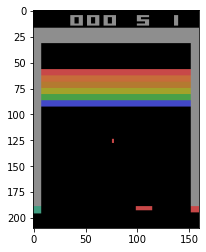

In [41]:
# Display first frame/image from first expeience/sequence
# Recall observation is a numpy array, stored in sequential_frame_buffer[][]
%matplotlib inline
plt.imshow(sequential_frame_buffer[0][0])

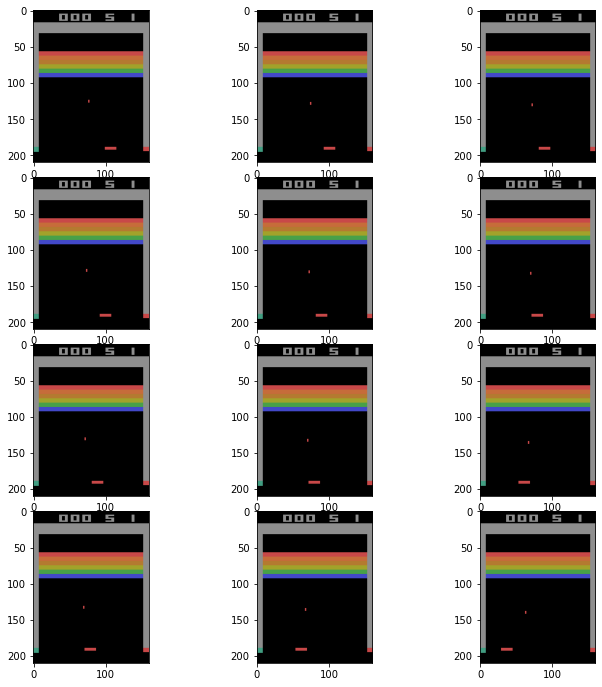

In [34]:
# Show first 4 experiences/sequences 
%matplotlib inline
fig, axis = plt.subplots(4, WINDOW_LENGTH, figsize=(12, 12))
for global_index, timestep in enumerate(sequential_frame_buffer[:4]):
    for frame_index, frame in enumerate(timestep):
        axis[global_index][frame_index].imshow(frame)
fig.subplots_adjust(wspace=0, hspace=0.1)

## 2. Image Processing with Keras-RL2

In [35]:
from rl.core import Processor # process the image within the keras-rl training routine
from rl.memory import SequentialMemory # store the sequential frames

In [37]:
# Same thing as before, but automatically with Keras-RL2
# create a list of 1000 experiences, each experience containing WINDOW_LENGTH frames
memory = SequentialMemory(limit=1000, window_length=WINDOW_LENGTH)

## 3. Image Pre-Processing: Scale & Gray

Instead of doing al pre-processing (scale & gray) manually, we use the `Processor` class from Keras-RL2. It can perform many tasks: 

[Keras-RL2 Processor](https://github.com/keras-rl/keras-rl/blob/master/rl/core.py#L515)

Each processor can define the following methods:
1. `process_step(observation, reward, done, info)`: "processes an entire step by applying the processor to the observation, reward, and info arguments". Used during **inference**.
2. `process_observation(observation)`: "processes the observation as obtained from the environment for use in an agent and returns it".
3. `process_reward(reward)`: "processes the reward as obtained from the environment for use in an agent and returns it".
4. `process_info(info)`: "processes the info as obtained from the environment for use in an agent and returns it".
5. `process_action(action)`: "processes an action predicted by an agent but before execution in an environment".
6. `process_state_batch(batch)`: "processes an entire batch of states and returns it". Used for **training**.

The processor transforms the observation provided by gym into something our network can handle.

We inherit the class and add overload the `process_observation` method.

In [38]:
# Scale: target size
IMG_SHAPE =  (84,84)

In [40]:
class BreakOutProcessor(Processor):
    def process_observation(self, observation):
        # numpy -> PIL Image
        img = Image.fromarray(observation)
        # Resize the image
        img = img.resize(IMG_SHAPE)
        # Grayscale  (L = luminance)
        img = img.convert("L")
        # PIL -> numpy
        return np.array(img)

In [42]:
# Test the inherited Processor
sample_images = []
breakout_proc = BreakOutProcessor()
env.reset()
for _ in range(200):
    action = env.action_space.sample() # sample random action
    observation, r, d, info = env.step(action) # perform random action and get next state
    # HERE WE TRANSFORM THE OBSERVATION/IMAGE
    processed_observation = breakout_proc.process_observation(observation)
    sample_images.append(processed_observation)

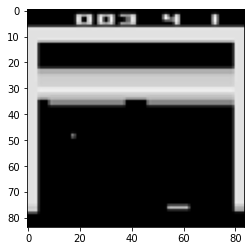

In [45]:
plt.imshow(sample_images[-1],cmap='gray')